<a href="https://colab.research.google.com/github/VivekanandaMudelli/hand_drawn_sketch_recognition/blob/main/linear_SVM(OVR)_(CNN%2BPCA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [29]:
class OneVsRestSVM:
    def __init__(self, C, max_iter):
        self.C = C
        self.max_iter = max_iter
        self.classifiers = {}

    def fit(self, X, y):
        self.unique_classes = np.unique(y)
        for cls in tqdm(self.unique_classes, desc="Training OVR Classifiers"):
            binary_y = np.where(y == cls, 1, -1)
            clf = LinearSVC(C=self.C, max_iter=self.max_iter)
            clf.fit(X, binary_y)
            self.classifiers[cls] = clf

    def predict(self, X):
        scores = {}
        for cls, clf in self.classifiers.items():
            scores[cls] = clf.decision_function(X)

        predictions = []
        for i in range(len(X)):
            class_scores = {cls: scores[cls][i] for cls in self.unique_classes}
            predicted_class = max(class_scores, key=class_scores.get)
            predictions.append(predicted_class)
        return predictions


In [30]:
# Load dataset
file_path = '/content/drive/MyDrive/prml/cnn_features.csv'
data = pd.read_csv(file_path)
X = data.drop(data.columns[0], axis=1).drop(["extracted_part", "encoded_part"], axis=1)
y = data["encoded_part"]

# Split into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

# Scale features
scaler = StandardScaler()  # Initialize scaler outside the loop

# Try PCA with different number of components and collect results

Training OVR Classifiers: 100%|██████████| 250/250 [00:10<00:00, 22.82it/s]


Validation Accuracy with 15 PCA components: 29.1111%


Training OVR Classifiers: 100%|██████████| 250/250 [00:16<00:00, 14.78it/s]


Validation Accuracy with 25 PCA components: 40.7778%


Training OVR Classifiers: 100%|██████████| 250/250 [00:24<00:00, 10.33it/s]


Validation Accuracy with 35 PCA components: 45.5000%


Training OVR Classifiers: 100%|██████████| 250/250 [00:31<00:00,  8.01it/s]


Validation Accuracy with 45 PCA components: 48.4444%


Training OVR Classifiers: 100%|██████████| 250/250 [00:37<00:00,  6.69it/s]


Validation Accuracy with 55 PCA components: 50.4444%


Training OVR Classifiers: 100%|██████████| 250/250 [00:46<00:00,  5.41it/s]


Validation Accuracy with 65 PCA components: 50.2222%


Training OVR Classifiers: 100%|██████████| 250/250 [00:59<00:00,  4.20it/s]


Validation Accuracy with 75 PCA components: 50.3333%


Training OVR Classifiers: 100%|██████████| 250/250 [01:15<00:00,  3.32it/s]


Validation Accuracy with 85 PCA components: 51.0000%


Training OVR Classifiers: 100%|██████████| 250/250 [01:32<00:00,  2.70it/s]


Validation Accuracy with 95 PCA components: 50.1111%


Training OVR Classifiers: 100%|██████████| 250/250 [01:58<00:00,  2.11it/s]


Validation Accuracy with 105 PCA components: 51.2778%


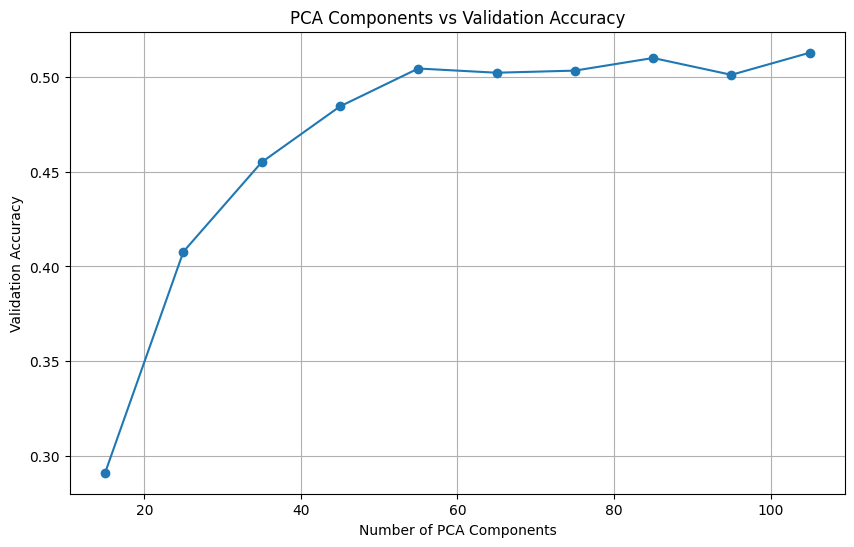


Best PCA Components based on validation: 105, Accuracy: 0.5128%


Training OVR Classifiers: 100%|██████████| 250/250 [02:04<00:00,  2.00it/s]



Final Test Accuracy with 105 PCA components: 51.2500%


In [31]:
component_range = range(15, min(X.shape[1], 110), 10)
accuracies = []
for n in component_range:
    pca = PCA(n_components=n)

    # Fit and transform on scaled training data
    X_train_scaled = scaler.fit_transform(X_train) #Moved inside the loop to scale before each PCA fitting.
    X_train_pca = pca.fit_transform(X_train_scaled) #This should now be using the correct scaled data

    #Only transform the validation data
    X_val_scaled = scaler.transform(X_val) #Moved inside the loop to scale before each PCA transform using the training data's scaling.
    X_val_pca = pca.transform(X_val_scaled) #This should now be using the correct scaled data

    model = OneVsRestSVM(C=1.0, max_iter=1000)
    model.fit(X_train_pca, y_train)
    y_val_pred = model.predict(X_val_pca)

    acc = accuracy_score(y_val, y_val_pred)
    accuracies.append(acc)
    print(f"Validation Accuracy with {n} PCA components: {acc*100:.4f}%")

    # Plot PCA components vs validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(component_range, accuracies, marker='o', linestyle='-')
plt.title("PCA Components vs Validation Accuracy")
plt.xlabel("Number of PCA Components")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

# Best number of components
best_n = component_range[np.argmax(accuracies)]
print(f"\nBest PCA Components based on validation: {best_n}, Accuracy: {max(accuracies*100):.4f}%")

# Final training on train+val with best PCA
X_trainval_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=best_n)
X_trainval_pca = pca.fit_transform(X_trainval_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = OneVsRestSVM(C=1.0, max_iter=1000)
model.fit(X_trainval_pca, y_train_val)
y_test_pred = model.predict(X_test_pca)

# Final test accuracy
final_acc = accuracy_score(y_test, y_test_pred)
print(f"\nFinal Test Accuracy with {best_n} PCA components: {final_acc*100:.4f}%")